In [1]:
import os
import pickle
import datetime
import warnings

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

import tensorflow as tf
import madmom

from segment import segment_spectrogram
from modules.labels import get_label_vector, shuffle_frames, get_label_table
from modules.madmom_cnn_prep import cnn_preprocessor, cnn_normalize
from datasets import Dataset
from analyze_detection import evaluate, f_score
from models.bock2013pret import get_model

%load_ext autoreload
%autoreload 2

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

SR = 44100
FPS = 100
CONTEXT = 7

In [2]:
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds2 = Dataset("slurtest_add_2")
ds3 = Dataset("slurtest_test")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths() + ds2.get_audio_paths() + ds3.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths() + ds2.get_annotation_paths() + ds2.get_annotation_paths()


audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
for ele in sample_rates:
    if ele != SR:
        print("Some sample rates are not equal to 44.1kHz!")

# TODO move to mixed dataset (not based on recordings)
# TODO investigate sample rate problem


Some sample rates are not equal to 44.1kHz!
Some sample rates are not equal to 44.1kHz!
Some sample rates are not equal to 44.1kHz!


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [3]:
# Load preprocessing funciton
preprocessor = cnn_preprocessor()
box_processor = madmom.features.onsets.CNNOnsetProcessor()

In [5]:
# Add white noise to recordings
# Noise variance is adjusted to a fixed Signal Noise Ratio computed recording-wise
# snr_db = 20 means S/N=10
# snr_db = 10 means S/N≈3.2
SNR_DB = 10
snr_v = 10**(SNR_DB/20)

def augmentation(audio, t=None, p=None):
    if t==None:
        return audio
    elif t=="white_noise":
        # p contains snr_db parameter
        return audio+np.random.normal(
            scale=madmom.audio.signal.root_mean_square(audio)/(10**(p/20)),
            size=audio.shape
            )

for audio, fname in zip(audios, audio_fnames):
    np.save("dataset/augmented/" + os.path.basename(fname) + "_noise_SNRdB_"+SNR_DB)

# TODO enable augmentation


TypeError: can only concatenate str (not "int") to str

In [4]:
onset_vectors = [get_label_vector(sched, len(audio)/sr, FPS)
    for (sched, audio, sr) in zip(onset_schedules, audios, sample_rates)
]

In [5]:
# Create data and normalize
mm_proc_frames = [preprocessor(fname) for fname in audio_fnames]
mm_frames_normalized = [cnn_normalize(frame_set) for frame_set in mm_proc_frames]


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [6]:
def data_generator(
    batch_size,
    steps_per_epoch,
    epochs,
    idx, 
    sampling=True,
    mode=None,
    standard=False,
    mean=None,
    std=None, 
    single_channel=False
):
    
    #for _ in range(steps_per_epoch * epochs):
    if not sampling:
        ep = 0
        file_p = 0
        frame_p = 0
    
    while True:
        # Select indices for training or test
        if sampling:
            file_i = np.random.choice(idx)
        else:
            file_i = idx[file_p]
        
        #print("Selected file index: ", file_i)
        fname = audio_fnames[file_i]
        
        if mode=="use_prep_frames":
            frames = mm_frames_normalized[file_i]
        elif mode=="use_raw_frames":
            # No normalization
            frames = mm_proc_frames[file_i]    
        else:
            # Compute frames
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fxn()
                frames = cnn_normalize(preprocessor(fname))

        if standard:
            frames = (frames-mean)/std
            
        #print("Frame size: ", frames.shape[0])

        # Retrieve onsets 
        onsets = onset_vectors[file_i]
        #print("Computed frames of size ", frames.shape)
        #print("Onset vectors have len ", len(onsets))

        # Sample a set of indices (defined from audio start,
        # that is CONTEXT values counted from x array start)
        if sampling:
            focus_idx = np.random.choice(
                np.arange(frames.shape[0]-2*CONTEXT-1), 
                size=batch_size
            )
            #print("Sampled focus idx between ", 0, " and ", frames.shape[0]-2*CONTEXT-1)
        else:
            #print("Focus idx from ", frame_p, " to ", frame_p+batch_size)
            focus_idx = np.arange(frame_p, frame_p+batch_size)
        

        # Segmentation
        x = [frames[focus:focus+2*CONTEXT+1,:,:] for focus in focus_idx]
        if single_channel:
            x = np.transpose(np.stack(x,0)[:,:,:,0], [0,2,1])
        else:   
            x = np.transpose(np.stack(x, 0), [0,2,1,3])
        #print("Segmented x has shape ", x.shape)
        if x.shape[0] != batch_size:
            print("Delivering less than batch-size")

        # Labels
        y = onsets[focus_idx]
        yield (x, y)

        if not sampling:
            if frame_p + 2*batch_size >= frames.shape[0]-2*CONTEXT-1:
                if file_p == len(idx) - 1:
                    ep += 1
                    print("Generator reached end of epoch. Resetting...")
                    file_p = 0
                    frame_p = 0
                else:
                    file_p += 1
                    frame_p = 0
            else:
                frame_p += batch_size
            

In [7]:
# Custom split:
n_splits = 1
split_at_rec = 18
folds = [[np.arange(split_at_rec), np.arange(split_at_rec, len(audio_fnames))]]
folds = [[[1], [2]]]


In [7]:
# Stratified by musician
sa_recs = list(np.arange(19)) + [23, 25, 28, 32, 36, 37, 45, 46]
fk_recs = [22, 29, 30, 33, 44, 47]
ir_recs = np.setdiff1d(list(np.arange(49)), sa_recs + fk_recs)

random_seed = 119
n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

folds = list(skf.split(
    np.concatenate((sa_recs, ir_recs)), # Indices in devset
    np.concatenate((np.zeros(len(sa_recs)), np.ones(len(ir_recs)))) # Boolean whether recs are played by a certain musician
))


In [80]:
# K-Fold:
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
folds = list(kf.split(np.arange(len(audio_fnames))))

In [8]:
# Precompute statistics
means_per_fold = []
std_per_fold = []
onset_ratios = []
for train_idx, test_idx in folds:
    train_frames = np.concatenate([mm_proc_frames[i] for i in train_idx]) 
    mean_train = train_frames.mean(0)
    std_train = train_frames.std(0, ddof=1)
    means_per_fold.append(np.expand_dims(mean_train, axis=0))
    std_per_fold.append(np.expand_dims(std_train, axis=0))

#with open('results/computed/added_means_by_fold.pickle', 'wb') as file_pi:
#    pickle.dump(means_per_fold, file_pi)
#with open('results/computed/added_std_by_fold.pickle', 'wb') as file_pi:
#    pickle.dump(std_per_fold, file_pi)



In [9]:
def compute_steps(idx, bs):
    song_sizes = np.array([len(f) for f in mm_proc_frames])[idx]-2*CONTEXT-1
    steps_per_song = np.floor_divide(song_sizes, bs)
    return np.sum(steps_per_song)

In [10]:
datasets = "full"
continue_run = False
training_mode = 0 # REMEMBER TO CHANGE
check_at_epoch = None

custom_model = False

save = False # REMEMBER TO CHANGE
 # REMEMBER TO CHANGE
save_path = "results/cnn-training-220425/" # TODO - automatically
n_epochs = 10 # REMEMBER TO CHANGE
learning_r = 0.0005
bs = 256
steps_per_epoch = int(np.sum(np.array([len(f) for f in mm_proc_frames])[folds[0][0]]-2*CONTEXT-1)/bs)
val_steps_per_epoch = 100
nogen = False
sampling = False
l2_lambda = 0 # DEFAULT: 0.01
dropout_p = 0.0
W = np.sum([len(vec) for vec in onset_vectors])/np.sum([vec.sum() for vec in onset_vectors])

finetune = False

standard = True # keep in mind on which data format statistics are computed 
mode = 'use_prep_frames' # Preparing by BN layer/"CNN normalization"
mode = 'use_raw_frames' # No preparing


training_name = "{}-{}-{}eps-lr{:.4f}-{}".format(
    datasets, 
    "nogen" if nogen else ("sample" if sampling else "seq"),
    n_epochs,
    learning_r,
    "standard" if standard else "nostandard"
)


In [11]:
def wbce(y_true, y_pred):
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1-1e-7)
    logits = tf.keras.backend.log(y_pred/(1-y_pred))
    return tf.nn.weighted_cross_entropy_with_logits(
        y_true, logits, W
    )

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()
metrics = [
    wbce
    #tf.keras.metrics.TruePositives(name='tp', thresholds=0.5),
    #tf.keras.metrics.TrueNegatives(name='tn', thresholds=0.5),
    #tf.keras.metrics.FalsePositives(name='fp', thresholds=0.5),
    #tf.keras.metrics.FalseNegatives(name='fn', thresholds=0.5),
]

In [12]:
from keras.regularizers import l2

model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(80, 15)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, 
            trainable = True,
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
        ),
        tf.keras.layers.Dense(64, 
            trainable = True,
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
        ),
        tf.keras.layers.Dense(1, 
            activation = "sigmoid",
            kernel_regularizer=l2(l2_lambda),
            bias_regularizer=l2(l2_lambda)
    )  
    ])

2022-10-22 14:46:44.304685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 14:46:44.318039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 14:46:44.318802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-22 14:46:44.320294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
#if standard:
#    with open('results/computed/added_means_by_fold.pickle', 'rb') as file_pi:
#        means = pickle.load(file_pi)
#    with open('results/computed/added_std_by_fold.pickle', 'rb') as file_pi:
#        stds = pickle.load(file_pi)

from numpy import single


if isinstance(training_mode, int):
    fold = training_mode
else:
    fold = 0

while fold < n_splits:
    print()
    print("Fold {}/{} ---------".format(fold, n_splits))
    train_idx = folds[fold][0]
    test_idx = folds[fold][1]
    print("Train indices: ", train_idx)
    print("Test indices: ", test_idx)

    # Data
    if nogen:
        X_train, X_test = [
            np.concatenate([X[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]
        y_train, y_test = [
            np.concatenate([onset_vectors[i] for i in idx]) 
            for idx in (train_idx, test_idx)
        ]

    #train_onset_ratio = y_train.sum()/len(y_train)

    # Normalize with training set statistics
    if standard:
        mean = means_per_fold[fold]
        std = std_per_fold[fold]
    else:
        mean, std = None, None

    # Model
    if not continue_run:
        tf.keras.backend.clear_session()
    if custom_model:
        model = model 
    else:
        (model, norm_layer)=get_model(finetune=finetune, l2_lambda=l2_lambda, dropout_p=dropout_p)
    model.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=metrics)
                
    if not sampling:
        steps_per_epoch = compute_steps(train_idx, bs)
        val_steps_per_epoch = compute_steps(test_idx, bs)

    if nogen:
        x = X_train
        y = y_train
        steps_per_epoch = None
        validation_data = (X_test, y_test)
    else:
        x = data_generator(
            batch_size=bs, 
            steps_per_epoch=steps_per_epoch, 
            epochs=n_epochs,
            idx=train_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
            single_channel=custom_model
        )
        y = None
        validation_data = data_generator(
            batch_size=bs, 
            steps_per_epoch=val_steps_per_epoch, 
            epochs=n_epochs,
            idx=test_idx,
            sampling=sampling,
            mode=mode,
            standard=standard, mean=mean, std=std,
            single_channel=custom_model
        )

    checkpoint_path = save_path + 'fold_{}_{}'.format(fold,training_name)+"_cp_{epoch:04d}.ckpt"
    if check_at_epoch is None:
        cp_callback=[]
    else:
        cp_callback = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                    save_weights_only=True,
                                                    save_freq=int(steps_per_epoch*check_at_epoch))]
    # Training
    """
    history = model.fit(
        x = x, y = y, 
        steps_per_epoch = steps_per_epoch,
        epochs          = n_epochs,
        # Validation data
        validation_data = validation_data,
        validation_steps  = val_steps_per_epoch,
        class_weight = {0:1, 1:W},
        callbacks=cp_callback,
        verbose=1
    )
"""

    # Saving
    if save:
        model.save(save_path + 'fold_{}_{}_model'.format(fold, training_name))
        with open(save_path + 'fold_{}_{}_history.pickle'.format(fold, training_name), 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    
    
    if training_mode != "all":
        break
    fold += 1

# TODO change class weights - should not be hardcoded


Fold 0/1 ---------
Train indices:  [1]
Test indices:  [2]


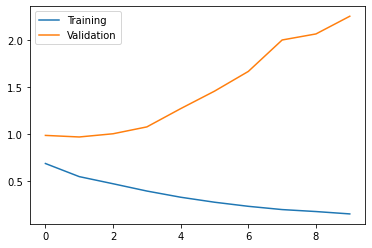

In [49]:
plt.plot(history.history['wbce'])
plt.plot(history.history['val_wbce'])
plt.legend(["Training", "Validation"])

: 

: 